## Expected Threat

[Expected Threat](https://karun.in/blog/expected-threat.html) article. Aim is to create a position based expected threat model like this article


In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
path = os.path.join(str(pathlib.Path().resolve()), 'Data', 'Wyscout', 'events','events_England.json')

with open(path) as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [3]:
df.shape

(643150, 12)

## Actions moving the ball

In [4]:
next_event = df.shift(-1, fill_value=0)
df['nextEvent'] = next_event['subEventName']

df['kickedOut'] = df.apply(lambda x: 1 if x['nextEvent'] == 'Ball out of the field' else 0, axis = 1)

# get move df
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

# filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]


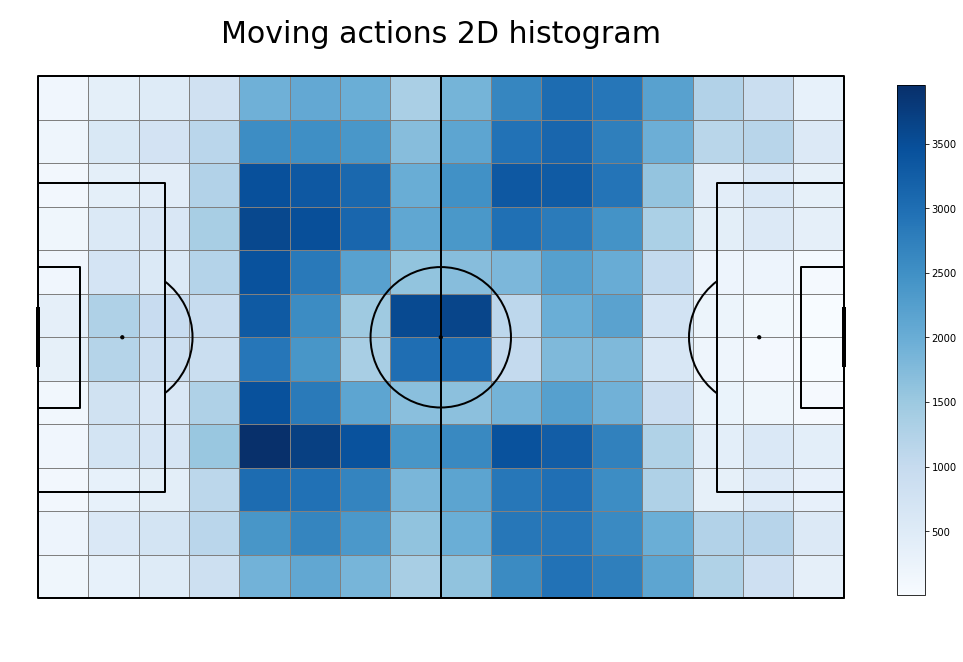

In [5]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()

#get the array
move_count = move["statistic"]

## Shots

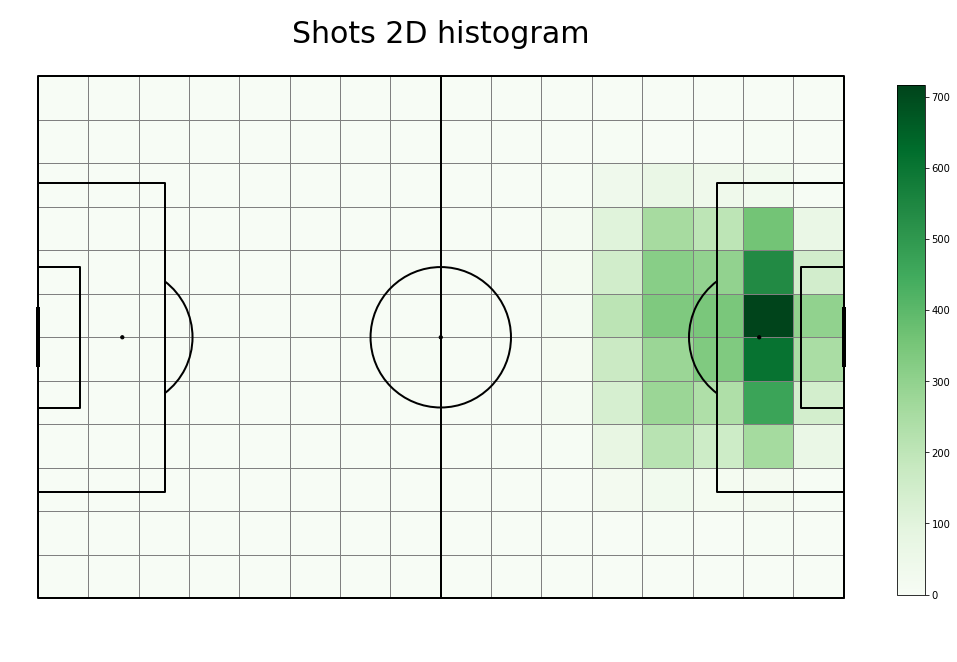

In [6]:
#get shot df
shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"] 

##### Practice with scipy method

Commented out, not necessary for the model just for practice

In [7]:
# shots = binned_statistic_2d(shot_df.x, shot_df.y, values = None, statistic='count', bins=(16, 12))

In [8]:
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)
# pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
# plt.show()

### Goals

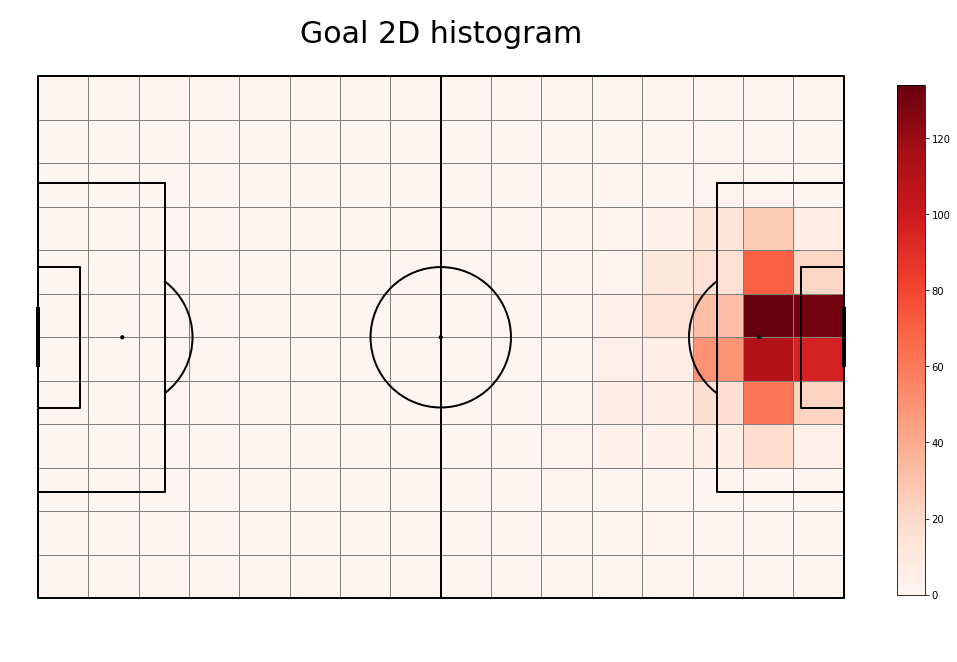

In [9]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

## Move Probability

We now need to calculate the probability of each moving action. To do so, we divide its number in each bin by the sum of moving actions and shots in that bin. Then, we plot it. Now have the probability of moving for each location/bin on the pitch

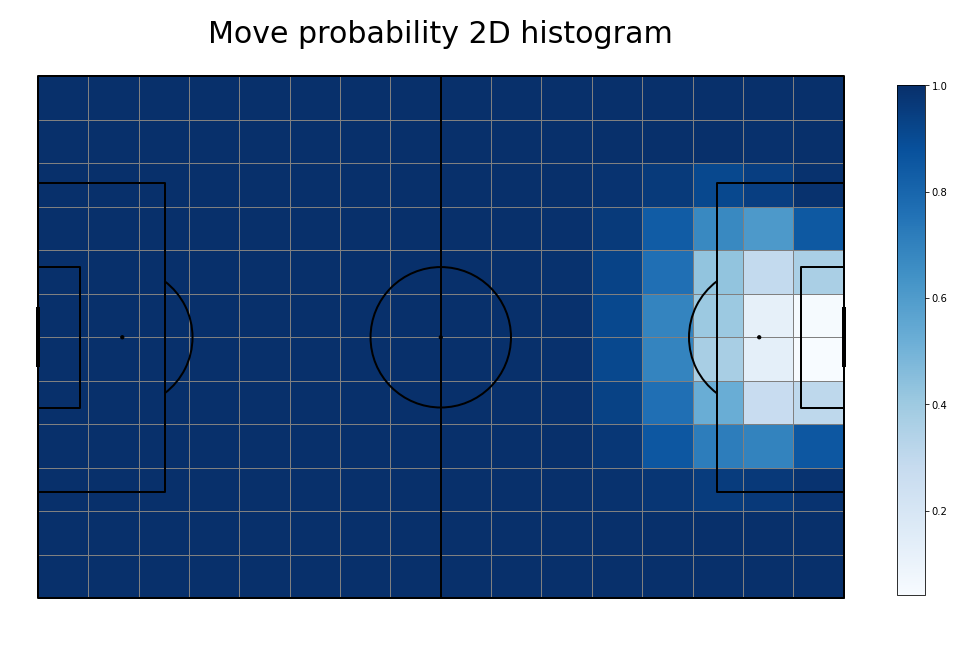

In [10]:
move_probability = move_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

## Shot Probability

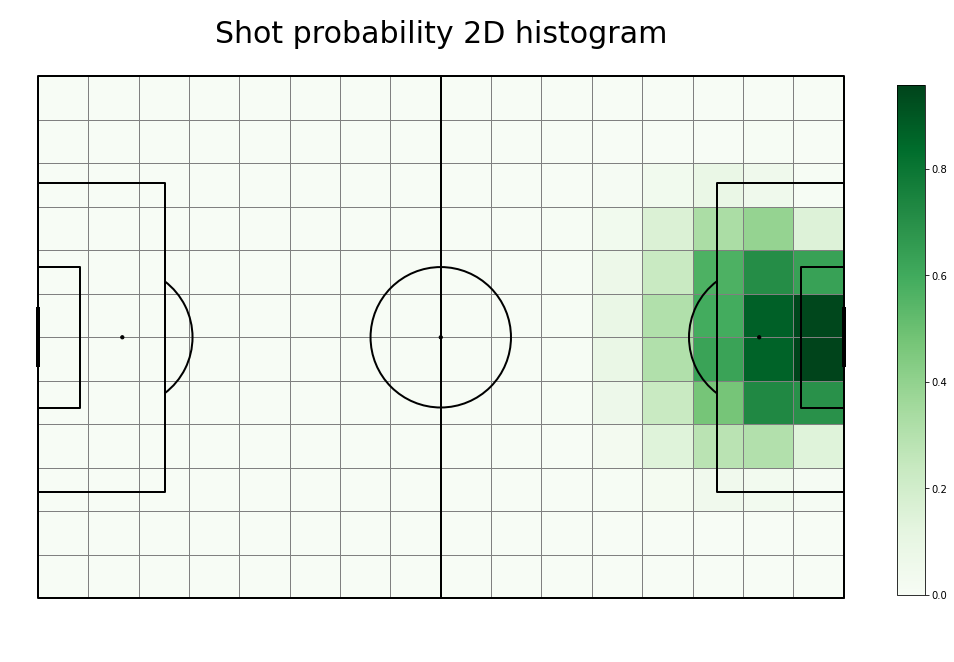

In [11]:
shot_probability = shot_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

## Goal Probability 

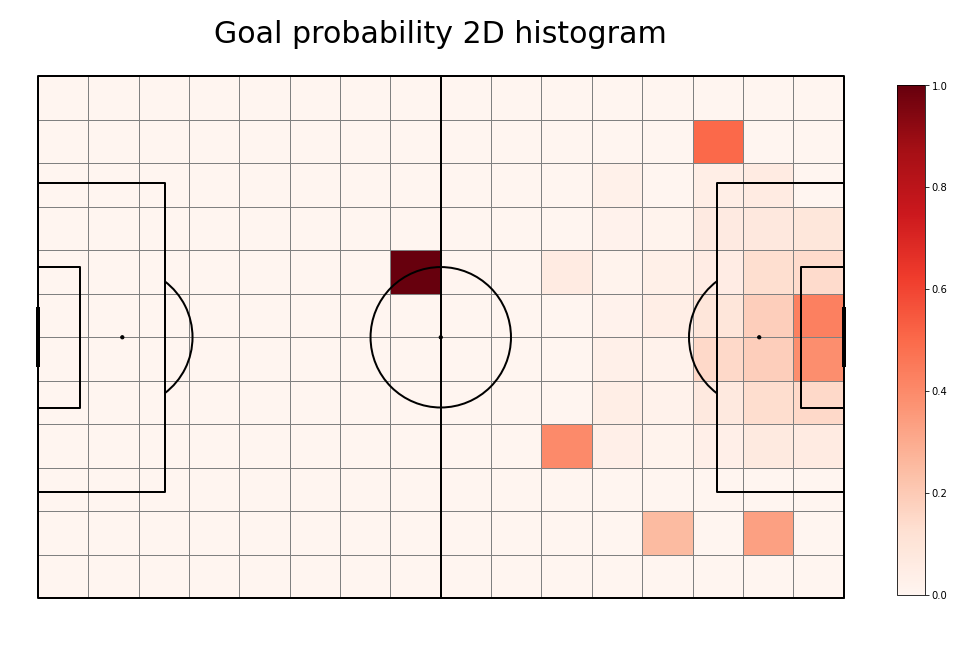

In [12]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

Could smooth data to make it more realisitc e.g gaussian smoothing

## Transition Matrices

In [13]:
#move start index - using the same function as mplsoccer, it should work

# for each row it finds the start x and y coord passed it into 2d histogram and finds which bin it is in
# this is then stored as a tuple in the new column start sector
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

In [14]:
# for each row it finds the end x and y coord passed it into 2d histogram and finds which bin it ends up in
# this is then stored as a tuple in the new column end sector

move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

In [15]:
#df with summed events from each index

# utilises the groupby function to count the number of events that occur in each bin
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

In [16]:
df_count_starts.head()

,start_sector,count_starts
0,"(1, 1)",168
1,"(1, 2)",224
2,"(1, 3)",134
3,"(1, 4)",162
4,"(1, 5)",136


In [17]:
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    # get all events that started in this sector
    # find all the sectors that event ended in and group by end_sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_count_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    # create an empty array dimensions = 12 * 16
    T_matrix = np.zeros((12, 16))
    
    # iterates through end count dataframe 
    # transposes index and subtracts 1 to make sure it is within range
    # assigns end count value
    # to find prob have to divide matrix by all counts that started in that sector
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

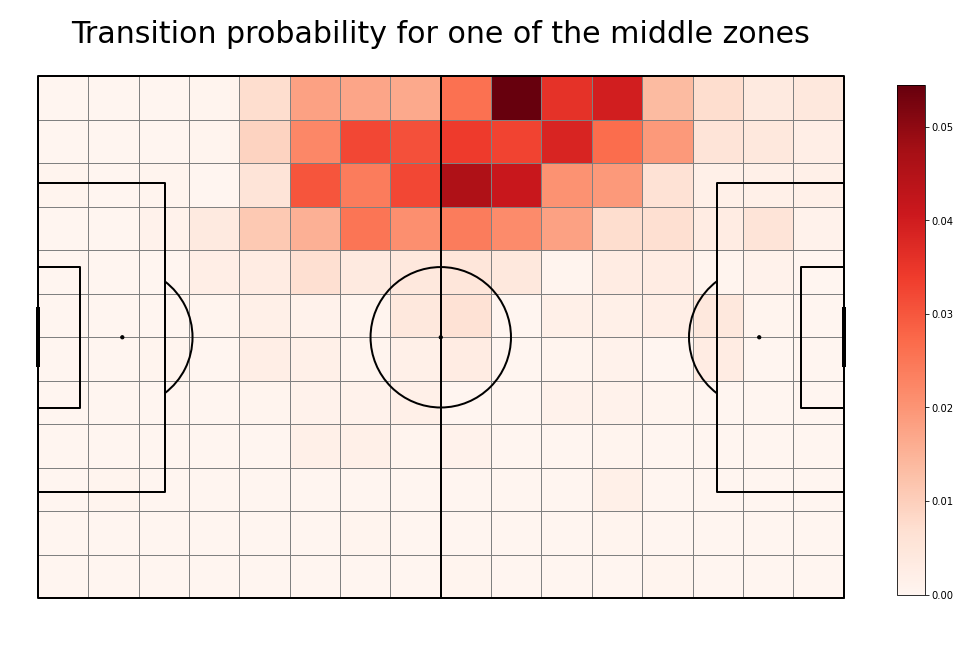

In [18]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[96]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

## Calculating Expected Threat Matrix

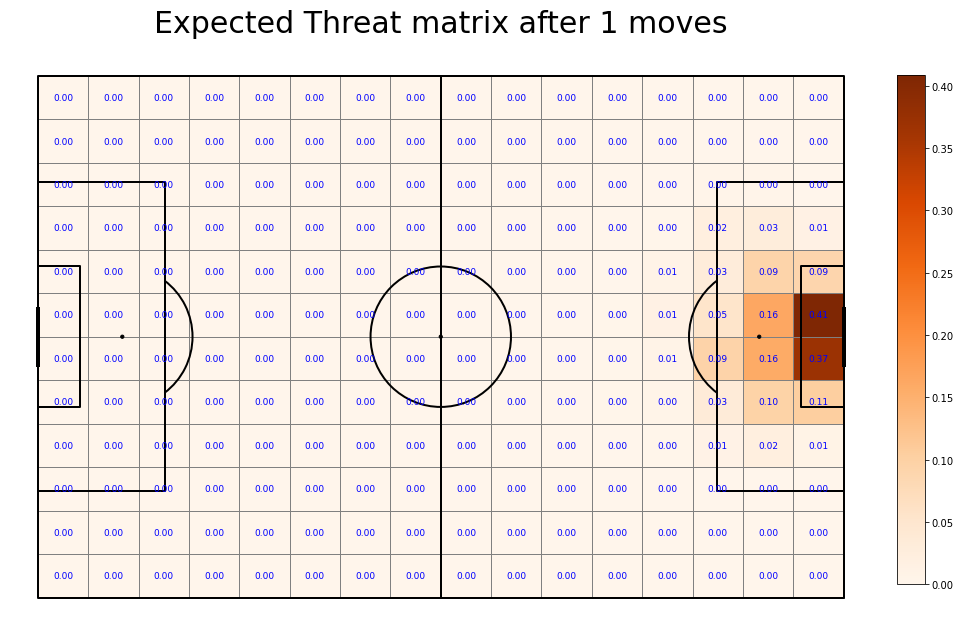

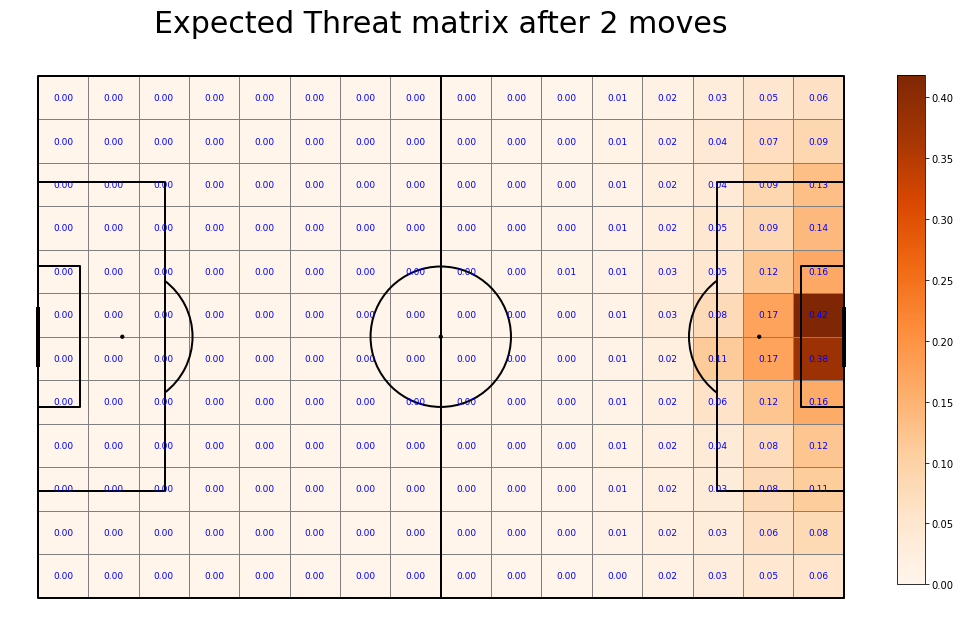

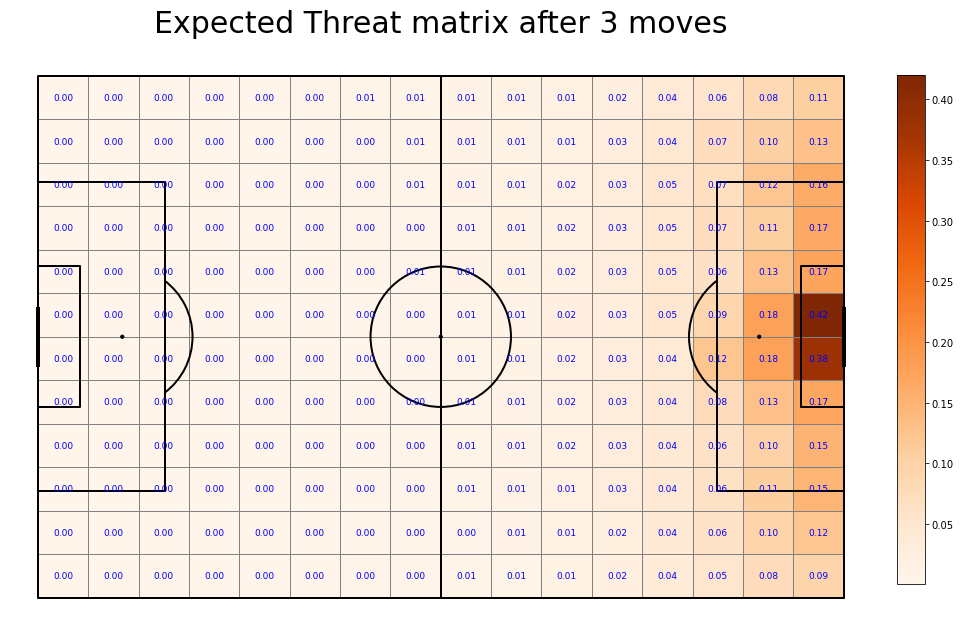

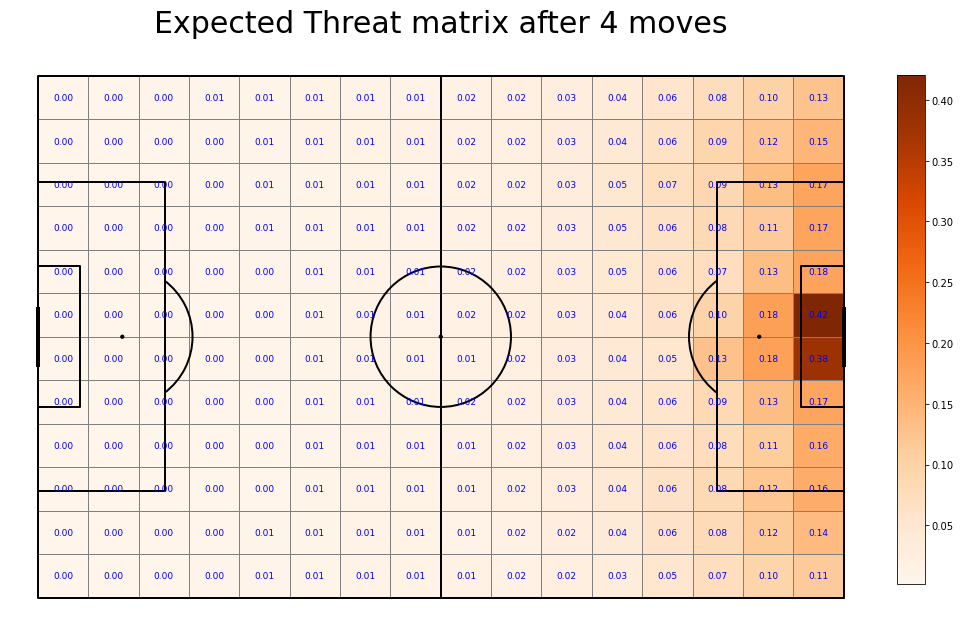

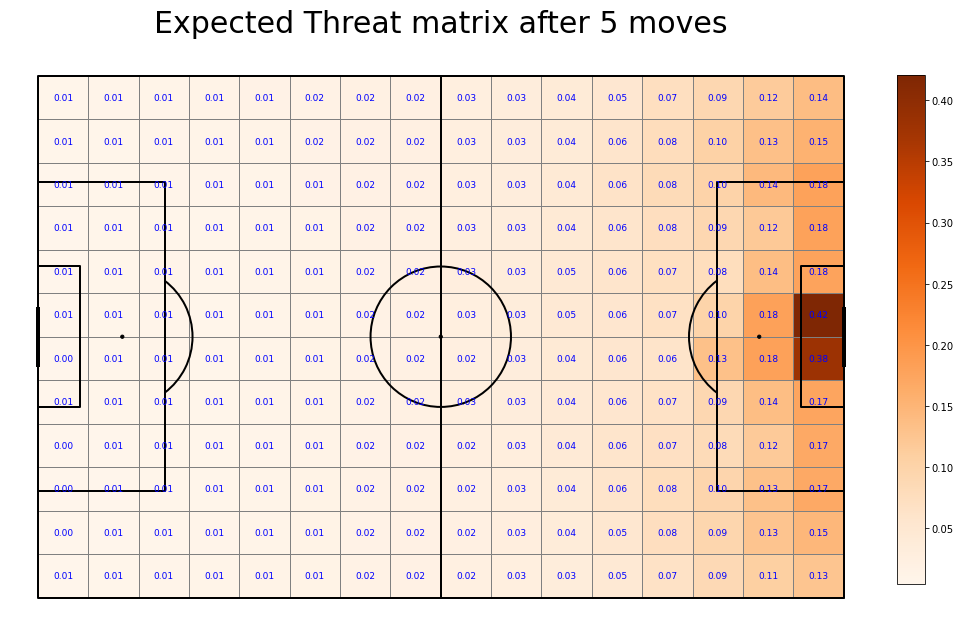

In [79]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability * shot_probability
    # have to do reshape(16,12).T to make sure bins are in the correct order when plotting
    move_expected_payoff = move_probability * (np.sum(np.sum(transition_matrices_array * xT, axis = 2), axis = 1).reshape(16,12).T)

    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Applying xT value to moving actions

In [84]:
#only successful
successful_moves = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

In [88]:
# calculate xT
# finds the difference in xT based on the sector end and start positions
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

In [89]:
#only progressive filter for xT greater than 0
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

## Finding Out Players with high xT

In [120]:
#group by player
xT_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()
xT_by_player.head()

,playerId,xT_added
0,36,9.684073
1,38,2.226775
2,48,19.732019
3,54,25.465235
4,56,0.896195


### Finding Player Names

In [121]:
path = os.path.join(str(pathlib.Path().resolve()), 'Data', 'Wyscout', 'players.json')

with open(path) as f:
    data = json.load(f)
    
players = pd.DataFrame(data)
players.rename(columns = {'wyId':'playerId'}, inplace=True)
players["role"] = players.apply(lambda x: x.role["name"], axis = 1)
to_merge = players[['playerId', 'shortName', 'role']]
to_merge.head()

,playerId,shortName,role
0,32777,H. Tekin,Goalkeeper
1,393228,M. Sarr,Defender
2,393230,O. Mandanda,Goalkeeper
3,32793,A. N'Diaye,Midfielder
4,393247,I. Konat\u00e9,Defender


In [122]:
summary = xT_by_player.merge(to_merge, how = "left", on = ["playerId"])
summary.sort_values('xT_added', ascending = False).head()

,playerId,xT_added,shortName,role
322,38021,37.807262,K. De Bruyne,Midfielder
32,3350,28.666155,F\u00e0bregas,Midfielder
331,49876,28.548984,G. Xhaka,Midfielder
139,8317,27.636851,David Silva,Midfielder
385,105339,26.217192,Fernandinho,Midfielder


In [123]:
path = os.path.join(str(pathlib.Path().resolve()), 'Data', 'Wyscout','minutes_played', 'minutes_played_per_game_England.json')

with open(path) as f:
    data = json.load(f)
    
minutes_per_game = pd.DataFrame(data)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head()

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343
3,54,3348
4,56,266


In [124]:
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

summary.head()

,playerId,minutesPlayed,xT_added,shortName,role
0,36,1238,9.684073,T. Alderweireld,Defender
2,48,3343,19.732019,J. Vertonghen,Defender
3,54,3348,25.465235,C. Eriksen,Midfielder
5,74,1514,8.096305,R. Klavan,Defender
6,93,2942,8.366193,J. Gu\u00f0munds\u00adson,Midfielder


In [125]:
#calculating per 90
summary["xT_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]
summary.head()

,playerId,minutesPlayed,xT_added,shortName,role,xT_per_90
0,36,1238,9.684073,T. Alderweireld,Defender,0.704012
2,48,3343,19.732019,J. Vertonghen,Defender,0.531224
3,54,3348,25.465235,C. Eriksen,Midfielder,0.684549
5,74,1514,8.096305,R. Klavan,Defender,0.481286
6,93,2942,8.366193,J. Gu\u00f0munds\u00adson,Midfielder,0.255934


In [126]:
path = os.path.join(str(pathlib.Path().resolve()), 'Data', 'Wyscout','minutes_played', 'player_possesion_England.json')

with open(path) as f:
    data = json.load(f)
    
percentage_df = pd.DataFrame(data)
percentage_df.head()

,playerId,possesion
0,9206,0.446999
1,9127,0.439018
2,93,0.438288
3,9179,0.471322
4,10108,0.433335


In [127]:
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possesion"])*90/summary["minutesPlayed"]

In [130]:
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(20)

,shortName,xT_adjusted_per_90
27,F\u00e0bregas,1.954186
271,K. De Bruyne,1.546140
68,P. Pogba,1.517259
22,M. \u00d6zil,1.511402
78,J. Shelvey,1.453346
39,Philippe Coutinho,1.445208
117,David Silva,1.417882
77,J. Henderson,1.398503
118,J. Milner,1.352086
125,C. Brunt,1.315329
